In [ ]:
import os
from pathlib import Path

XML_DIR = Path("xml_files")
MODEL_DIR = Path("RoBERTa_prem_conc_finetuned")
OUTPUT_DIR = Path("graph_data")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

if not XML_DIR.exists():
    raise FileNotFoundError(f"XML directory not found: {XML_DIR}")
xml_files = [f for f in XML_DIR.glob("*.xml") if f.is_file()]
print(f"Found {len(xml_files)} XML files")


Found 40 XML files


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModel.from_pretrained(MODEL_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import xml.etree.ElementTree as ET

def process_xml(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        nodes = []
        id_registry = set()
        for elem in root.iter():
            if elem.tag not in ('prem', 'conc'):
                continue
                
            node_id = elem.attrib.get('ID', '').strip()
            if not node_id or node_id in id_registry:
                continue
                
            nodes.append({
                'id': node_id,
                'text': elem.text.strip() if elem.text else '',
                'type': elem.tag,
                'xml_file': xml_path.name
            })
            id_registry.add(node_id)
            
        id_to_idx = {node['id']: idx for idx, node in enumerate(nodes)}
        
        edges = {'support': [], 'attack': []}
        for elem in root.iter():
            if elem.tag not in ('prem', 'conc'):
                continue
                
            source_id = elem.attrib.get('ID', '').strip()
            if not source_id or source_id not in id_to_idx:
                continue

            def clean_split(value):
                return [t.strip() for t in value.strip().split('|') if t.strip()]
                
            for rel_type in ['SUP', 'ATT']:
                if rel_type in elem.attrib:
                    targets = clean_split(elem.attrib[rel_type])
                    edge_key = 'support' if rel_type == 'SUP' else 'attack'
                    
                    for target_id in targets:
                        if target_id in id_to_idx:
                            edges[edge_key].append((
                                source_id, 
                                target_id,
                                id_to_idx[source_id],
                                id_to_idx[target_id]
                            ))
                            print(f"Added {edge_key} edge: {source_id} → {target_id}")
                        else:
                            print(f"Ignoring invalid target: {target_id} for {source_id}")
        
        return nodes, edges, id_to_idx
        
    except ET.ParseError as e:
        print(f"XML parse error in {xml_path.name}: {e}")
        return [], {'support': [], 'attack': []}, {}


In [ ]:
from tqdm import tqdm

def generate_embeddings(texts, batch_size=4):
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch, 
            padding=True, 
            truncation=True, 
            max_length=512, 
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        embeddings.append(outputs.last_hidden_state[:,0,:].cpu())
    
    return torch.cat(embeddings, dim=0)


In [ ]:
def add_strategic_negative_samples(nodes, edges, id_map, support_ratio=1.0, attack_ratio=5.0):
    existing_edges = set()
    for rel_type, rel_edges in edges.items():
        for edge in rel_edges:
            src_id, tgt_id = edge[:2]
            existing_edges.add((id_map[src_id], id_map[tgt_id]))
    
    support_count = sum(1 for edge in edges['support'])
    attack_count = sum(1 for edge in edges['attack'])
    
    all_nodes = list(range(len(nodes)))
    
    node_texts = [node["text"] for node in nodes]
    node_types = [node["type"] for node in nodes]
    
    no_relation_candidates = []
    for src in all_nodes:
        for tgt in all_nodes:
            if src != tgt and (src, tgt) not in existing_edges:
                src_type = node_types[src]
                tgt_type = node_types[tgt]
                priority = 2 if (src_type == "prem" and tgt_type == "conc") else 1
                
                no_relation_candidates.append((src, tgt, priority))
    
    no_relation_candidates.sort(key=lambda x: x[2], reverse=True)
    
    support_target = int(support_count * support_ratio)
    attack_target = int(attack_count * attack_ratio)
    total_target = support_target + attack_target
    total_target = min(total_target, len(no_relation_candidates))
    
    sampled_edges = [(src, tgt) for src, tgt, _ in no_relation_candidates[:total_target]]
    
    print(f"Added {len(sampled_edges)} No-Relation edges - balancing {support_count} support and {attack_count} attack edges")
    return sampled_edges


In [ ]:
import torch
from torch_geometric.data import Data

all_data = []

for xml_file in tqdm(xml_files, desc="Processing XML files"):
    print("------------------------------------------------------------------- processing ", xml_file)
    nodes, edges, id_map = process_xml(xml_file)
    
    texts = [node["text"] for node in nodes]
    embeddings = generate_embeddings(texts)
    
    type_features = torch.zeros((len(nodes), 2))
    for i, node in enumerate(nodes):
        type_features[i, 0 if node["type"] == "prem" else 1] = 1
    
    node_features = torch.cat([embeddings, type_features], dim=1)
    
    edge_indices = []
    edge_types = []
    
    for rel_type, rel_edges in edges.items():
        for edge in rel_edges:  
            src_id, tgt_id = edge[:2]  
            if src_id in id_map and tgt_id in id_map:
                edge_indices.append([id_map[src_id], id_map[tgt_id]])
                edge_types.append(0 if rel_type == "support" else 1)

    negative_edges = add_strategic_negative_samples(nodes, edges, id_map, support_ratio=1.0, attack_ratio=5.0)
    for src, tgt in negative_edges:
        edge_indices.append([src, tgt])
        edge_types.append(2)  



    edge_index = torch.tensor(edge_indices).t().contiguous()
    edge_type = torch.tensor(edge_types)
    
    data = Data(
        x=node_features,
        edge_index=edge_index,
        edge_type=edge_type,
        xml_file=xml_file.name
    )
    
    output_path = OUTPUT_DIR / f"{xml_file.stem}.pt"
    torch.save(data, output_path)
    
    all_data.append(data)

print(f"Processed {len(all_data)} legal documents")


Processing XML files:   0%|          | 0/40 [00:00<?, ?it/s]

------------------------------------------------------------------- processing  xml_files/R2011_European Commission v Kronoply GmbH & Co (2).xml
Added support edge: A11 → A1
Added support edge: A11 → A2
Added support edge: A11 → A3
Added support edge: A11 → A3bis
Added support edge: A11 → A4
Added support edge: A11 → A5
Added support edge: A11 → A6
Added support edge: A11 → A7
Added support edge: A11 → A8
Added support edge: A11 → A9
Added support edge: A11 → A10
Added support edge: A19 → A18
Added support edge: A20 → A18
Added support edge: A22 → A15
Added support edge: A22 → A16
Added support edge: A22 → A17
Added support edge: A22 → A19
Added support edge: A22 → A20
Added support edge: A22 → A21
Added support edge: A23 → A15
Added support edge: A23 → A16
Added support edge: A23 → A17
Added support edge: A23 → A19
Added support edge: A23 → A20
Added support edge: A23 → A21
Added support edge: A24 → A25
Added support edge: A24 → A26
Added support edge: A24 → A27
Added support edge: A2

Processing XML files:   2%|▎         | 1/40 [00:00<00:19,  1.99it/s]

Added 48 No-Relation edges - balancing 48 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/A2018_Commission v Spain.xml
Added support edge: A5 → A1
Added support edge: A5 → A2
Added support edge: A5 → A3
Added support edge: A5 → A4
Ignoring invalid target: Rule for A8
Added support edge: A12 → A11
Added support edge: A19 → A17
Added support edge: A19 → A18
Added support edge: A22 → A19
Added support edge: A22 → A21
Added attack edge: A22 → A23
Added support edge: A24 → A8
Added support edge: A24 → A9
Added support edge: A24 → A9bis
Added support edge: A27 → A25
Added support edge: A27 → A26
Added support edge: A28 → A27
Added support edge: A31 → A29
Added support edge: A31 → A30
Added support edge: A32 → A10
Added support edge: A32 → A10bis
Added support edge: A32 → A10ter
Added support edge: A32 → A10quater
Added support edge: A32 → A10quinquies
Added support edge: A32 → A11
Added support edge: A32 → A12
Added support

Processing XML files:   5%|▌         | 2/40 [00:01<00:27,  1.37it/s]

Added 99 No-Relation edges - balancing 74 support and 5 attack edges
------------------------------------------------------------------- processing  xml_files/R2017_European Commission v Frucona Košice a.xml
Added support edge: A2 → A1
Added support edge: A6 → A7
Added support edge: A8 → A1
Added support edge: A8 → A2
Added support edge: A8 → A3
Added support edge: A8 → A4
Added support edge: A8 → A5
Added support edge: A8 → A6
Added support edge: A9 → A8
Added support edge: A10 → A9
Added support edge: A15 → A10
Added support edge: A15 → A13
Added support edge: A15 → A14
Added support edge: B2 → B1
Added support edge: B6 → B2
Added support edge: B6 → B3
Added support edge: B6 → B4
Added support edge: B6 → B5
Added support edge: C2 → C1
Added support edge: D3 → D2
Added support edge: D10 → D11
Added support edge: D10 → D12
Added support edge: D10 → D13
Added support edge: D10 → D14
Added support edge: D10 → D15
Added support edge: D16 → D11
Added support edge: D16 → D12
Added support e

Processing XML files:   8%|▊         | 3/40 [00:01<00:21,  1.69it/s]

Added 56 No-Relation edges - balancing 56 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/A2018_Dirk Andres v European Commission.xml
Added support edge: A3 → A1
Added attack edge: A3 → A4
Added attack edge: A4 → A12
Added support edge: A7 → A5
Added support edge: A7 → A6
Added support edge: A10 → A9
Added support edge: A11 → A7
Added support edge: A11 → A8
Added support edge: A11 → A10
Added support edge: A15 → A13
Added support edge: A15 → A14
Added support edge: A16 → A5
Added support edge: A16 → A3
Added support edge: A16 → A15
Added support edge: A17 → A5
Added support edge: A17 → A3
Added support edge: A17 → A15
Added support edge: A20 → A16
Added support edge: A20 → A17
Added support edge: A20 → A18
Added support edge: A20 → A19
Added attack edge: B1 → B1
Added support edge: B5 → B2
Added support edge: B5 → B3
Added support edge: B5 → B4
Added support edge: B7 → B5
Added support edge: B7 → B5bis
Added support e

Processing XML files:  10%|█         | 4/40 [00:02<00:22,  1.57it/s]

Added 98 No-Relation edges - balancing 73 support and 5 attack edges
------------------------------------------------------------------- processing  xml_files/A2017_European Commission v Italian Republic_DT.xml
Added support edge: A9 → A3
Added support edge: A9 → A4
Added support edge: A9 → A5
Added support edge: A9 → A6
Added support edge: A9 → A7
Added support edge: A9 → A8
Added support edge: A11 → A1
Added support edge: A11 → A2
Added support edge: A11 → A9
Added support edge: A11 → A10
Added support edge: A12 → A11
Added support edge: B7 → B2
Added support edge: B7 → B3
Added support edge: B7 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added attack edge: B7 → B26
Added support edge: B9 → B1
Added support edge: B9 → B7
Added support edge: B14 → B12
Added support edge: B14 → B13
Added support edge: B15 → B12
Added support edge: B15 → B13
Added support edge: B18 → B1
Added support edge: B18 → B9
Added support edge: B18 → B10
Added support edge: B18 → B11
Added suppor

Processing XML files:  12%|█▎        | 5/40 [00:02<00:19,  1.80it/s]

Added 64 No-Relation edges - balancing 59 support and 1 attack edges
------------------------------------------------------------------- processing  xml_files/R2016_DTS Distribuidora de Televisión Digital.xml
Added support edge: A1 → A2
Added support edge: A3 → A1
Added support edge: A4 → A3
Added support edge: A6 → A7
Added support edge: A8 → A9
Added support edge: A11 → A12
Added support edge: A13 → A4
Added support edge: A13 → A5
Added support edge: A13 → A6
Added support edge: A13 → A8
Added support edge: A13 → A10
Added support edge: A13 → A11
Added support edge: B2 → B1
Added support edge: B3 → B2
Added support edge: B5 → B6
Added support edge: B5 → B7
Added support edge: B5 → B8
Added support edge: B5 → B9
Added support edge: B11 → B10
Added support edge: B11 → B12
Added support edge: B13 → B3
Added support edge: B13 → B4
Added support edge: B13 → B5
Added support edge: B13 → B11
Added support edge: C3 → C1
Added support edge: C3 → C2
Added support edge: D1 → D5
Added support ed

Processing XML files:  15%|█▌        | 6/40 [00:03<00:20,  1.63it/s]

Added 114 No-Relation edges - balancing 84 support and 6 attack edges
------------------------------------------------------------------- processing  xml_files/R2021_FVE Holýšov I and Others v Commission.xml
Added support edge: A1 → A2
Added support edge: A4 → A1
Added support edge: B5 → B1
Added support edge: B5 → B2
Added support edge: B5 → B3
Added support edge: B5 → B4
Added support edge: B6 → B5
Added support edge: C4 → C3
Added support edge: C5 → C1
Added support edge: C5 → C2
Added support edge: C5 → C4
Added support edge: C6 → C7
Added support edge: C10 → C11
Added support edge: C12 → C5
Added support edge: C12 → C6
Added support edge: C12 → C7
Added support edge: C12 → C9
Added attack edge: D1 → D2
Added support edge: D2 → D3
Added support edge: D2 → D3bis
Added support edge: D2 → D4
Added support edge: D4 → D2
Added attack edge: D5 → D6
Added attack edge: D5 → D7
Added support edge: D8 → D6
Added support edge: D8 → D7
Added attack edge: D9 → D10
Added support edge: D12 → D4
A

Processing XML files:  18%|█▊        | 7/40 [00:03<00:17,  1.91it/s]

Added 74 No-Relation edges - balancing 34 support and 8 attack edges
------------------------------------------------------------------- processing  xml_files/R2016_European Commission v Hansestadt Lübeck.xml
Added support edge: A6 → A5
Added support edge: A7 → A1
Added support edge: A7 → A2
Added support edge: A7 → A3
Added support edge: A7 → A4
Added support edge: A7 → A6
Added support edge: A11 → A7
Added support edge: A11 → A8
Added support edge: B3 → B2
Added support edge: B11 → B8
Added support edge: B11 → B9
Added support edge: B11 → B10
Added support edge: B13 → B1
Added support edge: B13 → B3
Added support edge: B13 → B4
Added support edge: B13 → B5
Added support edge: B13 → B6
Added support edge: B13 → B7
Added support edge: B13 → B11
Added support edge: B13 → B12
Added support edge: B14 → B13
Added support edge: C8 → C1
Added support edge: C8 → C1bis
Added support edge: C8 → C1ter
Added support edge: C8 → C1quater
Added support edge: C8 → C1quinquies
Added support edge: C8 →

Processing XML files:  20%|██        | 8/40 [00:04<00:17,  1.82it/s]

Added 65 No-Relation edges - balancing 65 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/R2017__Viasat Broadcasting UK Ltd v European Commission.xml
Added support edge: A6 → A2
Added support edge: A6 → A3
Added support edge: A6 → A4
Added support edge: A6 → A5
Added support edge: A7 → A1
Added support edge: A7 → A1bis
Added support edge: A7 → A6
Added support edge: A8 → A7
Added support edge: B1 → B12
Added attack edge: B1 → B18
Added support edge: B7 → B2
Added support edge: B7 → B2bis
Added support edge: B7 → B2ter
Added support edge: B7 → B3
Added support edge: B7 → B3bis
Added support edge: B7 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added support edge: B7 → B6a
Added support edge: B7 → B6b
Added support edge: B7 → B6c
Added support edge: B7 → B6d
Added attack edge: B12 → B13
Added support edge: B13 → B7
Added support edge: B13 → B8
Added support edge: B13 → B9
Added support edge: B13 → B10
Ad

Processing XML files:  22%|██▎       | 9/40 [00:04<00:15,  2.03it/s]

Added 57 No-Relation edges - balancing 42 support and 3 attack edges
------------------------------------------------------------------- processing  xml_files/R2006_European Commission v Italian Republic.xml
Added attack edge: A2 → A5
Added support edge: A5 → A3
Added support edge: A5 → A4
Added support edge: A9 → A6
Added support edge: A9 → A7
Added support edge: A9 → A8
Added support edge: A10 → A9
Added support edge: A11 → A1
Added support edge: A11 → A5
Added support edge: A11 → A10
Added support edge: B10 → B16
Added support edge: B13 → B1
Added support edge: B13 → B2
Added support edge: B13 → B3
Added support edge: B13 → B4
Added support edge: B13 → B5
Added support edge: B13 → B14
Added support edge: B13 → B15
Added support edge: B16 → B17
Added support edge: B16 → B22
Added support edge: B16 → B23
Added support edge: B17 → B13
Added support edge: B17 → B11
Added support edge: B17 → B12
Added support edge: B17 → B6
Added support edge: B17 → B7
Added support edge: B17 → B18
Added

Processing XML files:  25%|██▌       | 10/40 [00:05<00:12,  2.35it/s]

Added 43 No-Relation edges - balancing 38 support and 1 attack edges
------------------------------------------------------------------- processing  xml_files/R2016_Netherlands Maritime Technology Association formerly Scheepsbouw Nederland v European Commission.xml
Added attack edge: A1 → A2
Added attack edge: A2 → A6
Added support edge: A6 → A3
Added support edge: A6 → A4
Added support edge: A6 → A5
Added support edge: A8 → A7
Added support edge: A10 → A8
Added support edge: A10 → A9
Added attack edge: A16 → A20
Added support edge: A20 → A17
Added support edge: A20 → A18
Added support edge: A20 → A19
Added attack edge: A22 → A22
Added support edge: A24 → A20
Added support edge: A24 → A21
Added support edge: A24 → A23
Added support edge: A25 → A10
Added support edge: A25 → A15
Added support edge: A25 → A24
Added support edge: B4 → B1
Added support edge: B4 → B2
Added support edge: B4 → B3
Added support edge: B8 → B4
Added support edge: B8 → B5
Added support edge: B8 → B6
Added support 

Processing XML files:  28%|██▊       | 11/40 [00:05<00:12,  2.33it/s]

Added 108 No-Relation edges - balancing 58 support and 10 attack edges
------------------------------------------------------------------- processing  xml_files/R2016_Orange v European Commission.xml
Added attack edge: A2 → A24
Added attack edge: A2 → A25
Added attack edge: A2 → A27
Added support edge: A6 → A5
Added support edge: A6 → A7
Added support edge: A6 → A8
Added support edge: A6 → A10
Added support edge: A10 → A9
Added support edge: A11 → A5
Added support edge: A11 → A7
Added support edge: A11 → A8
Added support edge: A11 → A10
Added support edge: A12 → A6
Added support edge: A12 → A11
Added support edge: A15 → A13
Added support edge: A15 → A14
Added support edge: A18 → A17
Added support edge: A19 → A15
Added support edge: A19 → A16
Added support edge: A19 → A18
Added support edge: A21 → A19
Added support edge: A21 → A20
Added attack edge: A22 → A24
Added attack edge: A22 → A25
Added attack edge: A22 → A27
Added attack edge: A23 → A24
Added attack edge: A23 → A25
Added attack 

Processing XML files:  30%|███       | 12/40 [00:06<00:12,  2.22it/s]

Added 114 No-Relation edges - balancing 69 support and 9 attack edges
------------------------------------------------------------------- processing  xml_files/A2016_European_Commission_v_World_Duty_Free.xml
Added support edge: A2 → A1
Added support edge: A2 → A1bis
Added support edge: A2 → A1ter
Added support edge: A2 → A1quater
Added support edge: A2 → A1quinquies
Added support edge: A3 → A1
Added support edge: A4 → A3
Added support edge: A5 → A3
Added support edge: A6 → A2
Added support edge: A6 → A4
Added support edge: A6 → A5
Added support edge: A7 → A1
Added support edge: A9 → A6
Added support edge: A9 → A7
Added support edge: A9 → A8
Added support edge: A12 → A11
Added support edge: A12 → A9
Added support edge: A12 → A18
Added support edge: A13 → A12
Added support edge: A17 → A22
Added support edge: A17 → A37
Added support edge: A17 → A42
Added support edge: A17 → A45
Added support edge: A18 → A6
Added support edge: A18 → A7
Added support edge: A18 → A8
Added support edge: A19 →

Processing XML files:  32%|███▎      | 13/40 [00:06<00:14,  1.91it/s]

Added 75 No-Relation edges - balancing 70 support and 1 attack edges
------------------------------------------------------------------- processing  xml_files/R2021_World Duty Free v. Commission.xml
Added support edge: A2 → A1
Added support edge: A3 → A2
Added support edge: A6 → A5
Added support edge: A8 → A4
Added support edge: A8 → A6
Added support edge: A8 → A7
Added support edge: B2 → B1
Added support edge: B3 → B2
Added support edge: B5 → B3
Added support edge: B5 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added support edge: B14 → B7
Added support edge: B14 → B8
Added support edge: B14 → B9
Added support edge: B14 → B10
Added support edge: B14 → B11
Added support edge: B14 → B12
Added support edge: B14 → B13
Added attack edge: B15 → B34
Added attack edge: B15 → B40
Added attack edge: B15 → B39
Added attack edge: B15 → B62
Added attack edge: B15 → B71
Added support edge: B16bis → B16ter
Added support edge: B16bis → B16quater
Added attack edge: B16bis → B33
Added 

Processing XML files:  35%|███▌      | 14/40 [00:08<00:18,  1.41it/s]

Added 226 No-Relation edges - balancing 116 support and 22 attack edges
------------------------------------------------------------------- processing  xml_files/A2017_Ellinikos Chrysos AE Metalleion kai Viomichanias Chrysou v European Commission.xml
Added attack edge: A4 → A4bis
Added support edge: A10 → A5
Added support edge: A10 → A6
Added support edge: A10 → A7
Added support edge: A10 → A8
Added support edge: A10 → A9
Added support edge: A14 → A13
Added support edge: A16 → A2
Added support edge: A16 → A10
Added support edge: A16 → A11
Added support edge: A16 → A12
Added support edge: A16 → A14
Added support edge: A16 → A15
Added support edge: A17 → A3
Added support edge: A17 → A3bis
Added support edge: A17 → A4bis
Added support edge: B4 → B1
Added support edge: B4 → B3
Added support edge: B7 → B6
Added support edge: B10 → B5
Added support edge: B10 → B7
Added support edge: B10 → B8
Added support edge: B10 → B9
Added support edge: B11 → B4
Added support edge: B11 → B10


Processing XML files:  38%|███▊      | 15/40 [00:08<00:14,  1.78it/s]

Added 29 No-Relation edges - balancing 24 support and 1 attack edges
------------------------------------------------------------------- processing  xml_files/R2012_European Commission v Électricité de France (EDF).xml
Added attack edge: A1 → A18
Added attack edge: A2 → A25
Added attack edge: A3 → A31
Added attack edge: A4 → A37
Added support edge: A10 → A5
Added support edge: A10 → A6
Added support edge: A10 → A7
Added support edge: A10 → A8
Added support edge: A10 → A9
Added support edge: A11 → A10
Added support edge: A12 → A11
Ignoring invalid target: Princ for A14
Ignoring invalid target: Prec for A15
Ignoring invalid target: Itpr for A15
Added support edge: A18 → A12
Added support edge: A18 → A13
Added support edge: A18 → A14
Added support edge: A18 → A15
Added support edge: A18 → A16
Added support edge: A18 → A17
Added support edge: A21 → A7
Added support edge: A21 → A20
Added support edge: A23 → A22
Added support edge: A24 → A23
Added support edge: A25 → A19
Added support edge: 

Processing XML files:  40%|████      | 16/40 [00:08<00:12,  1.96it/s]

Added 77 No-Relation edges - balancing 52 support and 5 attack edges
------------------------------------------------------------------- processing  xml_files/R2010_AceaElectrabel Produzione SpA v European Commission.xml
Added support edge: A2 → A1
Added support edge: A2 → A5
Added support edge: A6 → A2
Added support edge: B11 → B2
Added support edge: B11 → B3
Added support edge: B11 → B8
Added support edge: B11 → B9
Added support edge: B11 → B10
Added support edge: B11 → B9bis
Added support edge: B12 → B4
Added support edge: B12 → B5
Added support edge: B12 → B6
Added support edge: B12 → B7
Added support edge: B12 → B8
Added support edge: B12 → B9
Added support edge: B12 → B10
Added support edge: B12 → B9bis
Added support edge: B14 → B1
Added support edge: B14 → B11
Added support edge: B14 → B12
Added support edge: B14 → B13
Added support edge: B16 → B15
Added support edge: B17 → B16
Added support edge: B21 → B20
Added support edge: B24 → B25
Added support edge: B24 → B26
Added suppor

Processing XML files:  42%|████▎     | 17/40 [00:09<00:11,  1.97it/s]

Added 65 No-Relation edges - balancing 65 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/A2018_Scuola Elementare Maria Montessori Srl v European Commission (2).xml
Added support edge: A2 → A1
Added support edge: A2 → A1bis
Added support edge: A3 → A3bis
Added support edge: A3 → A4
Added support edge: A3 → A5
Added support edge: A3 → A6
Added support edge: A3 → A7
Added support edge: A8 → A1
Added support edge: A8 → A2
Added support edge: A8 → A3
Added support edge: A9 → A3
Added support edge: A12 → A10
Added support edge: A12 → A13
Added support edge: A14 → A11
Added support edge: A14 → A12
Added support edge: A14 → A15
Added support edge: A14 → A16
Added support edge: A17 → A14
Added support edge: A19 → A21
Added support edge: A19 → A23
Added support edge: A20 → A18
Added support edge: A21 → A20
Added support edge: A21 → A22
Added support edge: A23 → A20
Added support edge: A23 → A22
Added support edge: A24 → A19
Ad

Processing XML files:  45%|████▌     | 18/40 [00:10<00:15,  1.43it/s]

Added 121 No-Relation edges - balancing 106 support and 3 attack edges
------------------------------------------------------------------- processing  xml_files/R2013_Telefónica SA v European Commission.xml
Added support edge: A9 → A8
Added attack edge: A12 → A18
Added support edge: A17 → A1
Added support edge: A17 → A2
Added support edge: A17 → A3
Added support edge: A17 → A4
Added support edge: A17 → A5
Added support edge: A17 → A6
Added support edge: A17 → A7
Added support edge: A17 → A9
Added support edge: A17 → A10
Added support edge: A17 → A11
Added support edge: A17 → A13
Added support edge: A17 → A14
Added support edge: A17 → A15
Added support edge: A17 → A16
Added support edge: A19 → A17
Added support edge: A19 → A18
Added support edge: A20 → A19
Added support edge: B6bis → B1
Added support edge: B6bis → B2
Added support edge: B6bis → B3
Added support edge: B6bis → B4
Added support edge: B6bis → B5
Added support edge: B6bis → B6
Added support edge: B9 → B6
Added support edge: 

Processing XML files:  48%|████▊     | 19/40 [00:10<00:11,  1.77it/s]

Added 38 No-Relation edges - balancing 33 support and 1 attack edges
------------------------------------------------------------------- processing  xml_files/R2004_Ramondín SA and Ramondín Cápsulas SA (C-186_02 P) and Territorio Histórico de Álava - Diputación Foral de Álava (C-188_02 P) v Commission of the European Communities (2).xml
Added attack edge: A1 → A4
Added support edge: A3 → A2
Added support edge: A4 → A3
Added support edge: A4bis → A3
Added support edge: A7 → A4
Added support edge: A7 → A4bis
Added support edge: A7 → A5
Added support edge: A7 → A6
Added support edge: A7 → A6bis
Added support edge: A8 → A7
Added support edge: A8 → A7bis
Added support edge: A11 → A10
Added support edge: A13 → A12
Added support edge: A14 → A12
Added support edge: A15 → A12
Added support edge: A16 → A13
Added support edge: A16 → A14
Added support edge: A16 → A15
Added support edge: A17 → A13
Added support edge: A17 → A14
Added support edge: A17 → A15
Added support edge: A18 → A16
Added suppor

Processing XML files:  50%|█████     | 20/40 [00:10<00:09,  2.18it/s]

Added 35 No-Relation edges - balancing 30 support and 1 attack edges
------------------------------------------------------------------- processing  xml_files/R1997_Tiercé Ladbroke SA v Commission of the European Communities.xml
Added support edge: A2 → A1
Added support edge: A3 → A2
Added support edge: A4 → A3
Added attack edge: A6 → A9
Added attack edge: A7 → A9
Added attack edge: A8 → A21
Added attack edge: A8bis → A21
Added support edge: A9 → A5
Added support edge: A9 → A8
Added support edge: A9 → A8bis
Added support edge: A16 → A14
Added support edge: A16 → A15
Added support edge: A20 → A10
Added support edge: A20 → A11
Added support edge: A20 → A12
Added support edge: A20 → A13
Added support edge: A20 → A16
Added support edge: A20 → A17
Added support edge: A20 → A18
Added support edge: A20 → A19
Added support edge: A21 → A4
Added support edge: A21 → A6
Added support edge: A21 → A7
Added support edge: A21 → A20
Added support edge: A22 → A23
Added support edge: A24 → A21
Added supp

Processing XML files:  52%|█████▎    | 21/40 [00:10<00:06,  2.73it/s]

Added 43 No-Relation edges - balancing 23 support and 4 attack edges
------------------------------------------------------------------- processing  xml_files/A2009_3F v Commission of the European Communities.xml
Added attack edge: A1 → A27
Added attack edge: A2 → A3
Added attack edge: A2 → A4
Added support edge: A11 → A5
Added support edge: A11 → A6
Added support edge: A11 → A7
Added support edge: A11 → A8
Added support edge: A11 → A9
Added support edge: A11 → A10
Added support edge: A12 → A5
Added support edge: A12 → A6
Added support edge: A12 → A7
Added support edge: A12 → A7bis
Added support edge: A12 → A8
Added support edge: A12 → A9
Added support edge: A12 → A10
Added support edge: A13 → A11
Added support edge: A13 → A12
Added support edge: A15 → A14
Added support edge: A18 → A16
Added support edge: A18 → A17
Added support edge: A20 → A18
Added support edge: A20 → A19
Added support edge: A21 → A13
Added support edge: A21 → A22
Added support edge: A23 → A20
Added support edge: A23

Processing XML files:  55%|█████▌    | 22/40 [00:11<00:07,  2.44it/s]

Added 79 No-Relation edges - balancing 59 support and 4 attack edges
------------------------------------------------------------------- processing  xml_files/R2015_European Commission v MOL Magyar Olaj- és Gázipari Nyrt (1).xml
Added support edge: A3 → A1
Added support edge: A3 → A2
Added support edge: A7 → A4
Added support edge: A7 → A5
Added support edge: A7 → A6
Added support edge: A8 → A7
Added support edge: A8 → A9
Added support edge: A8 → A10
Added support edge: A8 → A11
Added support edge: A12 → A8
Added support edge: A17 → A3
Added support edge: A17 → A7
Added support edge: A17 → A12
Added support edge: A17 → A6
Added support edge: A18 → A17
Added support edge: B3 → B2
Added support edge: B4 → B2
Added support edge: B5 → B2
Added support edge: B6 → B3
Added support edge: B6 → B4
Added support edge: B6 → B5
Added support edge: B8 → B7
Added support edge: B10 → B1
Added support edge: B10 → B6
Added support edge: B10 → B9
Added support edge: C8 → C1
Added support edge: C8 → C2
Ad

Processing XML files:  57%|█████▊    | 23/40 [00:11<00:06,  2.47it/s]

Added 40 No-Relation edges - balancing 40 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/R2004_Daewoo Electronics Manufacturing España SA and Territorio Histórico de Álava - Diputación Foral de Álava v Commission of the European Communities.xml
Added support edge: A5 → A11
Added support edge: A6 → A7
Added support edge: A6 → A8
Added support edge: A6 → A9
Added support edge: A10 → A6
Added support edge: A11 → A10
Added support edge: A13 → A3
Added support edge: A13 → A4
Added support edge: A13 → A5
Added support edge: A13 → A11
Added support edge: A13 → A12
Added support edge: B2 → B1
Added support edge: B7 → B3
Added support edge: B7 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added support edge: B8 → B2
Added support edge: B8 → B7
Added support edge: C3 → C1
Added support edge: C3 → C2


Processing XML files:  60%|██████    | 24/40 [00:11<00:05,  2.96it/s]

Added 20 No-Relation edges - balancing 20 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/R2004_Italian Republic v Commission of the European Communities.xml
Added support edge: A5 → A2
Added support edge: A5 → A3
Added support edge: A5 → A4
Added support edge: A8 → A6
Added support edge: A8 → A7
Added support edge: A8 → A9
Added support edge: A8 → A10
Added support edge: A11 → A5
Added support edge: A11 → A5bis
Added support edge: A11 → A8
Added support edge: A12 → A11
Added support edge: B4 → B3
Added support edge: B9 → B5
Added support edge: B9 → B6
Added support edge: B9 → B7
Added support edge: B9 → B8
Added support edge: B12 → B1
Added support edge: B12 → B2
Added support edge: B12 → B4
Added support edge: B12 → B9
Added support edge: B12 → B10
Added support edge: B12 → B11
Added support edge: B13 → B12
Added support edge: C5 → C3
Added support edge: C5 → C4
Added support edge: C7 → C9
Added support edge: C9 → C

Processing XML files:  62%|██████▎   | 25/40 [00:12<00:06,  2.44it/s]

Added 67 No-Relation edges - balancing 67 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/A2010_NDSHT Nya Destination Stockholm Hotell & Teaterpaket AB v European Commission (1).xml
Added attack edge: A1 → A3
Added support edge: A4 → A2
Added support edge: A4 → A3
Added support edge: A5 → A4
Added support edge: B5 → B4
Added support edge: B6 → B4
Added support edge: B7 → B4
Added support edge: B10 → B9
Added support edge: B11 → B10bis
Added support edge: B19 → B18
Added support edge: B19 → B18bis
Added support edge: B20 → B16
Added support edge: B20 → B17
Added support edge: B20 → B19
Added support edge: B22 → B21
Added support edge: B24 → B22
Added support edge: B24 → B23
Added support edge: B25 → B13
Added support edge: B25 → B14
Added support edge: B25 → B24
Added support edge: B27 → B1
Added support edge: B27 → B2
Added support edge: B27 → B3
Added support edge: B27 → B5
Added support edge: B27 → B6
Added support 

Processing XML files:  65%|██████▌   | 26/40 [00:12<00:05,  2.69it/s]

Added 44 No-Relation edges - balancing 39 support and 1 attack edges
------------------------------------------------------------------- processing  xml_files/R2002_associação dos refinadores de açúcar portugueses.xml
Added attack edge: A1 → A7
Added support edge: A3 → A2
Added support edge: A5 → A4
Added support edge: A7 → A5
Added support edge: A7 → A6bis
Added support edge: B1 → B2
Added support edge: B1 → B5
Added support edge: B4 → B3
Added support edge: B5 → B4
Added support edge: B6 → B5
Added support edge: B8 → B13
Added support edge: B10 → B9
Added support edge: B11 → B10
Added support edge: B12 → B11
Added support edge: B13 → B12
Added support edge: B14 → B8
Added support edge: B16 → B15
Added support edge: B17 → B6
Added support edge: B17 → B14
Added support edge: B17 → B16
Added support edge: C8 → C7
Added support edge: C9 → C2
Added support edge: C9 → C2bis
Added support edge: C9 → C3
Added support edge: C9 → C4
Added support edge: C9 → C5
Added support edge: C9 → C8
Added

Processing XML files:  68%|██████▊   | 27/40 [00:13<00:05,  2.21it/s]

Added 105 No-Relation edges - balancing 95 support and 2 attack edges
------------------------------------------------------------------- processing  xml_files/A2009_Commission of the European Communities v Koninklijke FrieslandCampina NV_M.xml
Added support edge: A2 → A1
Added support edge: A4 → A2
Added support edge: A4 → A3
Added support edge: A5 → A1
Added support edge: A6 → A7
Added support edge: A6 → A7bis
Added support edge: A6 → A8
Added support edge: A7 → A5
Added support edge: A7bis → A5
Added support edge: A8 → A5
Added support edge: A11 → A9
Added support edge: A11 → A10
Added support edge: A14 → A11
Added support edge: A14 → A12
Added support edge: A14 → A13
Added support edge: A15 → A6
Added support edge: A15 → A14
Added support edge: A18 → A4
Added support edge: A18 → A14
Added support edge: A19 → A18
Added support edge: B4 → B1
Added support edge: B4 → B2
Added support edge: B4 → B3
Added support edge: B5 → B4
Added support edge: B6 → B7
Added support edge: B8 → B6
Adde

Processing XML files:  70%|███████   | 28/40 [00:13<00:05,  2.31it/s]

Added 48 No-Relation edges - balancing 48 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/A2013_Frucona Košice a.s. v European Commission.xml
Added support edge: A3 → A2
Added support edge: A4 → A2
Added support edge: A5 → A4
Added support edge: A6 → A7
Added support edge: A7 → A5
Added support edge: A8 → A6
Added support edge: A9 → A8
Added support edge: A12 → A1
Added support edge: A12 → A1bis
Added support edge: A12 → A1ter
Added support edge: A12 → A9
Added support edge: A12 → A10
Added support edge: A12 → A11
Added support edge: A15 → A13
Added support edge: A15 → A14
Added support edge: A17 → A12
Added support edge: A17 → A15
Added support edge: A17 → A16
Added support edge: A19 → A18
Added support edge: A21 → A12
Added support edge: A21 → A15
Added support edge: A21 → A16
Added support edge: A22 → A17
Added support edge: A22 → A20
Added support edge: A22 → A21
Added support edge: A23 → A22
Added support edge: A

Processing XML files:  72%|███████▎  | 29/40 [00:14<00:04,  2.53it/s]

Added 48 No-Relation edges - balancing 43 support and 1 attack edges
------------------------------------------------------------------- processing  xml_files/R2011_France Télécom SA v European Commission (2).xml
Added support edge: A3 → A2
Added support edge: A7 → A8
Added support edge: A7 → A9
Added support edge: A7 → A10
Added support edge: A13 → A1
Added support edge: A13 → A3
Added support edge: A13 → A4
Added support edge: A13 → A5
Added support edge: A13 → A6
Added support edge: A13 → A7
Added support edge: A13 → A11
Added support edge: A18 → A17
Added support edge: A19 → A20
Added support edge: A19 → A21
Added support edge: A22 → A13
Added support edge: A22 → A14
Added support edge: A22 → A15
Added support edge: A22 → A16
Added support edge: A22 → A18
Added support edge: A22 → A19
Added support edge: A23 → A22
Added support edge: B7 → A4
Added support edge: B7 → A5
Added support edge: B7 → A6
Added support edge: B14 → B14bis
Added support edge: B14 → B15
Added support edge: B14

Processing XML files:  75%|███████▌  | 30/40 [00:14<00:04,  2.21it/s]

Added 77 No-Relation edges - balancing 77 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/A2011_European Commission (C-106_09 P) and Kingdom of Spain (C-107_09 P) v Government of Gibraltar and United Kingdom of Great Britain and Northern Ireland.xml
Added support edge: A1 → A2
Added support edge: A3 → A5
Added support edge: A8 → A7
Added support edge: A10 → A8
Added support edge: A10 → A9
Added support edge: A14 → A15
Added support edge: A14 → A16
Added support edge: A14 → A17
Added support edge: A14 → A19
Added support edge: A14 → A20
Added support edge: A18 → A15
Added support edge: A18 → A16
Added support edge: A18 → A17
Added support edge: A18 → A19
Added support edge: A18 → A20
Added support edge: A21 → A1
Added support edge: A21 → A3
Added support edge: A21 → A13
Added support edge: A21 → A14
Added support edge: A21 → A18
Added support edge: B1 → B2
Added attack edge: B1 → B3
Added attack edge: B1 → B28
Added su

Processing XML files:  78%|███████▊  | 31/40 [00:15<00:03,  2.35it/s]

Added 56 No-Relation edges - balancing 46 support and 2 attack edges
------------------------------------------------------------------- processing  xml_files/R2000_French Republic v Ladbroke Racing Ltd and Commission of the European Communitie (2).xml
Added attack edge: A2 → A20
Added attack edge: A3 → A21
Added support edge: A7 → A5
Added support edge: A7 → A6
Added attack edge: A7 → A10
Added support edge: A10 → A4
Added support edge: A10 → A9
Added support edge: A10 → A10
Added support edge: A13 → A11
Added support edge: A13 → A12
Added attack edge: A13 → A30
Added support edge: A15 → A14
Added attack edge: A15 → A16
Added support edge: A17 → A20
Added support edge: A20 → A18
Added support edge: A20 → A19
Added support edge: A21 → A17
Added attack edge: A22 → A24
Added support edge: A24 → A23
Added support edge: A26 → A25
Added support edge: A27 → A28
Added support edge: A27 → A29
Added attack edge: A29 → A30
Added support edge: A30 → A33
Added support edge: A33 → A31
Added support

Processing XML files:  80%|████████  | 32/40 [00:15<00:03,  2.27it/s]

Added 127 No-Relation edges - balancing 47 support and 16 attack edges
------------------------------------------------------------------- processing  xml_files/A2017__European Commission v Italian Republic_DT.xml
Added support edge: A9 → A3
Added support edge: A9 → A4
Added support edge: A9 → A5
Added support edge: A9 → A6
Added support edge: A9 → A7
Added support edge: A9 → A8
Added support edge: A11 → A1
Added support edge: A11 → A2
Added support edge: A11 → A9
Added support edge: A11 → A10
Added support edge: A12 → A11
Added support edge: B7 → B2
Added support edge: B7 → B3
Added support edge: B7 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added attack edge: B7 → B26
Added support edge: B9 → B1
Added support edge: B9 → B7
Added support edge: B14 → B12
Added support edge: B14 → B13
Added support edge: B15 → B12
Added support edge: B15 → B13
Added support edge: B18 → B1
Added support edge: B18 → B9
Added support edge: B18 → B10
Added support edge: B18 → B11
Added sup

Processing XML files:  82%|████████▎ | 33/40 [00:16<00:03,  2.29it/s]

Added 64 No-Relation edges - balancing 59 support and 1 attack edges
------------------------------------------------------------------- processing  xml_files/A2008_Commission of the European Communities v Salzgitter AG.xml
Added support edge: A3 → A2
Added support edge: A7 → A6
Added support edge: A9 → A1
Added support edge: A9 → A3
Added support edge: A9 → A4
Added support edge: A9 → A5
Added support edge: A9 → A7
Added support edge: A9 → A8
Added support edge: A10 → A11
Added support edge: A13 → A9
Added support edge: A13 → A10
Added support edge: A13 → A12
Added support edge: A14 → A13
Added support edge: B2 → B1
Added support edge: C2 → C1
Added attack edge: D1 → D8
Added support edge: D8 → D2
Added support edge: D8 → D3
Added support edge: D8 → D4
Added support edge: D8 → D5
Added support edge: D8 → D6
Added support edge: D8 → D7
Added support edge: D9 → D8
Added support edge: E3 → E1
Added support edge: E3 → E2
Added support edge: E4 → E3
Added support edge: F2 → F1
Added suppor

Processing XML files:  85%|████████▌ | 34/40 [00:16<00:02,  2.37it/s]

Added 58 No-Relation edges - balancing 48 support and 2 attack edges
------------------------------------------------------------------- processing  xml_files/R2013_3F, formerly Specialarbejderforbundet i Danmark (SID) v European Commission.xml
Added support edge: A8 → A7
Added support edge: A9 → A4
Added support edge: A9 → A8
Added support edge: A9 → A8bis
Added support edge: A12 → A10
Added support edge: A12 → A11
Added attack edge: A13 → A18
Added support edge: A17 → A16
Added support edge: A18 → A1
Added support edge: A18 → A2
Added support edge: A18 → A3
Added support edge: A18 → A3bis
Added support edge: A18 → A4
Added support edge: A18 → A5
Added support edge: A18 → A6
Added support edge: A18 → A9
Added support edge: A18 → A12
Added support edge: A18 → A14
Added support edge: A18 → A15
Added support edge: A18 → A17
Added support edge: B2 → B3
Added support edge: B2 → B4
Added support edge: B5 → B2
Added attack edge: B10 → B13
Added support edge: B14 → B8
Added support edge: B14 

Processing XML files:  88%|████████▊ | 35/40 [00:16<00:02,  2.35it/s]

Added 54 No-Relation edges - balancing 44 support and 2 attack edges
------------------------------------------------------------------- processing  xml_files/R2021_Prosegur Compañía de Seguridad SA, established in Madrid (Spain) v Commission.xml
Added support edge: A2 → A1
Added support edge: A3 → A2
Added support edge: A6 → A5
Added support edge: A8 → A4
Added support edge: A8 → A6
Added support edge: A8 → A7
Added support edge: B2 → B1
Added support edge: B3 → B2
Added support edge: B5 → B3
Added support edge: B5 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added support edge: B14 → B7
Added support edge: B14 → B8
Added support edge: B14 → B9
Added support edge: B14 → B10
Added support edge: B14 → B11
Added support edge: B14 → B12
Added support edge: B14 → B13
Added attack edge: B15 → B34
Added attack edge: B15 → B40
Added attack edge: B15 → B39
Added attack edge: B15 → B62
Added attack edge: B15 → B71
Added support edge: B16bis → B16ter
Added support edge: B16bis → 

Processing XML files:  90%|█████████ | 36/40 [00:17<00:02,  1.58it/s]

Added 224 No-Relation edges - balancing 114 support and 22 attack edges
------------------------------------------------------------------- processing  xml_files/A2012__BNP Paribas and Banca Nazionale del Lavoro SpA (BNL) v European Commission.xml
Added support edge: A4 → A1
Added support edge: A4 → A2
Added support edge: A4 → A3
Added support edge: A4 → A3bis
Added support edge: A8 → A6
Added support edge: A8 → A7
Added support edge: A12bis → A9
Added support edge: A12bis → A9bis
Added support edge: A12bis → A9ter
Added support edge: A12bis → A10
Added support edge: A12bis → A11
Added support edge: A12bis → A12
Added support edge: A13 → A9
Added support edge: A13 → A12
Added support edge: A17 → A14
Added support edge: A17 → A15
Added support edge: A17 → A16
Added support edge: A19 → A18
Added support edge: A21 → A20
Added attack edge: B1 → B2
Added attack edge: B1 → B3
Added support edge: B4 → B1
Added support edge: B4 → B2
Added support edge: C9 → C8
Added support edge: C10 → C9
Adde

Processing XML files:  92%|█████████▎| 37/40 [00:18<00:01,  1.78it/s]

Added 48 No-Relation edges - balancing 28 support and 4 attack edges
------------------------------------------------------------------- processing  xml_files/R2016_Hellenic Republic v European Commission.xml
Added support edge: A2 → A1
Added support edge: A8 → A7
Added support edge: A9 → A6
Added support edge: A9 → A8
Added support edge: A10 → A9
Added support edge: A11 → A10
Added support edge: A15 → A14
Added support edge: A16 → A11
Added support edge: A16 → A12
Added support edge: A16 → A13
Added support edge: A16 → A15
Added support edge: A20 → A18
Added support edge: A20 → A19
Added support edge: A21 → A18
Added support edge: A21 → A19
Added support edge: A22 → A2
Added support edge: A22 → A3
Added support edge: A22 → A4
Added support edge: A22 → A5
Added support edge: A22 → A16
Added support edge: A22 → A20
Added support edge: A22 → A21
Added support edge: A26 → A2
Added support edge: A26 → A3
Added support edge: A26 → A4
Added support edge: A26 → A23
Added support edge: A26 → A

Processing XML files:  95%|█████████▌| 38/40 [00:18<00:01,  1.77it/s]

Added 90 No-Relation edges - balancing 90 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/A2013_European Commission v Ireland and Others.xml
Added support edge: A3 → A1
Added support edge: A3 → A2
Added support edge: A7 → A4
Added support edge: A7 → A5
Added support edge: A7 → A6
Added support edge: A9 → A10
Added support edge: A11 → A12
Added support edge: A13 → A3
Added support edge: A13 → A7
Added support edge: A13 → A8
Added support edge: A13 → A9
Added support edge: A13 → A11
Added support edge: A15 → A14
Added support edge: A25 → A15
Added support edge: A25 → A16
Added support edge: A25 → A17
Added support edge: A25 → A18
Added support edge: A25 → A19
Added support edge: A25 → A20
Added support edge: A25 → A21
Added support edge: A25 → A22
Added support edge: A25 → A23
Added support edge: A25 → A24
Added support edge: A27 → A28
Added support edge: A27 → A29
Added support edge: A27 → A30
Added support edge: A27 →

Processing XML files:  98%|█████████▊| 39/40 [00:19<00:00,  1.97it/s]

Added 47 No-Relation edges - balancing 47 support and 0 attack edges
------------------------------------------------------------------- processing  xml_files/A2016_European Commission v Aer Lingus Ltd and Ryanair Designated Activity Company.xml
Added attack edge: A3 → A4
Added support edge: A4 → A7
Added support edge: A7 → A5
Added support edge: A7 → A6
Added support edge: A8 → A1
Added support edge: A8 → A4
Added support edge: B2 → B3
Added support edge: B2 → B4
Added support edge: B5 → B2
Added support edge: C2 → C1
Added support edge: C4 → C1
Added support edge: C4 → C2
Added support edge: C4 → C3
Added support edge: C4 → C5
Added support edge: C4 → C8
Added support edge: C5 → C6
Added support edge: C5 → C7
Added support edge: C8 → C6
Added support edge: C8 → C7
Added support edge: C9 → C4
Added attack edge: C10 → C15
Added support edge: C12 → C2
Added support edge: C15 → C9
Added support edge: C15 → C11
Added support edge: C15 → C12
Added support edge: C15 → C13
Added support edge

Processing XML files: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]

Added 71 No-Relation edges - balancing 61 support and 2 attack edges
Processed 40 legal documents


In [ ]:
import torch
from pathlib import Path

def get_dataset_stats(output_dir="graph_data"):
    pt_files = list(Path(output_dir).glob("*.pt"))
    if not pt_files:
        return "No processed files found. Run XML processing first."

    total_stats = {
        'total_nodes': 0,
        'total_support': 0,
        'total_attack': 0,
        'total_no_relation': 0,  
        'files': []
    }


    for pt_file in pt_files:
        try:
            data = torch.load(pt_file, weights_only=False)
            support = (data.edge_type == 0).sum().item()
            attack = (data.edge_type == 1).sum().item()
            no_relation = (data.edge_type == 2).sum().item()  

            
            file_stats = {
                'filename': pt_file.name,
                'nodes': data.x.shape[0],
                'support': support,
                'attack': attack,
                'no_relation': no_relation
            }
            
            total_stats['total_nodes'] += file_stats['nodes']
            total_stats['total_support'] += support
            total_stats['total_attack'] += attack
            total_stats['total_no_relation'] += no_relation
            total_stats['files'].append(file_stats)
            
            
        except Exception as e:
            print(f"Error loading {pt_file.name}: {str(e)}")
    
    return total_stats

stats = get_dataset_stats()

print(f"""
## Dataset Summary
- **Total Documents**: {len(stats['files'])}
- **Total Arguments**: {stats['total_nodes']}
- **Support Relationships**: {stats['total_support']}
- **Attack Relationships**: {stats['total_attack']}
- **No-Relation Pairs**: {stats['total_no_relation']}
- **Ratio (Support:Attack:NoRel)**: {stats['total_support']}:{stats['total_attack']}:{stats['total_no_relation']}
""")

for file in stats['files']:
    print(f"""
**{file['filename']}**
- Nodes: {file['nodes']}
- Support: {file['support']}
- Attack: {file['attack']}
- No-Relation: {file['no_relation']}""")




## Dataset Summary
- **Total Documents**: 40
- **Total Arguments**: 2554
- **Support Relationships**: 2291
- **Attack Relationships**: 145
- **No-Relation Pairs**: 3016
- **Ratio (Support:Attack:NoRel)**: 2291:145:3016


**R2021_World Duty Free v. Commission.pt**
- Nodes: 147
- Support: 116
- Attack: 22
- No-Relation: 226

**R2013_Telefónica SA v European Commission.pt**
- Nodes: 37
- Support: 33
- Attack: 1
- No-Relation: 38

**A2018_Dirk Andres v European Commission.pt**
- Nodes: 74
- Support: 73
- Attack: 5
- No-Relation: 98

**A2012__BNP Paribas and Banca Nazionale del Lavoro SpA (BNL) v European Commission.pt**
- Nodes: 49
- Support: 28
- Attack: 4
- No-Relation: 48

**A2013_Frucona Košice a.s. v European Commission.pt**
- Nodes: 43
- Support: 43
- Attack: 1
- No-Relation: 48

**A2008_Commission of the European Communities v Salzgitter AG.pt**
- Nodes: 56
- Support: 48
- Attack: 2
- No-Relation: 58

**R2016_European Commission v Hansestadt Lübeck.pt**
- Nodes: 76
- Support: 65
- 

In [8]:
import numpy as np
torch.manual_seed(42)
np.random.seed(42)

dataset_size = len(all_data)
indices = np.random.permutation(dataset_size)
split_idx = int(0.8 * dataset_size)

train_docs = [all_data[i] for i in indices[:split_idx]]
test_docs = [all_data[i] for i in indices[split_idx:]]

print(f"\n## Dataset Split ##")
print(f"Training documents: {len(train_docs)}")
print(f"Test documents: {len(test_docs)}")



## Dataset Split ##
Training documents: 32
Test documents: 8


In [ ]:
def calculate_balanced_class_weights(data_list):
    total_support = sum((data.edge_type == 0).sum().item() for data in data_list)
    total_attack = sum((data.edge_type == 1).sum().item() for data in data_list)
    total_no_relation = sum((data.edge_type == 2).sum().item() for data in data_list)
    
    total_samples = total_support + total_attack + total_no_relation
    
    support_w = total_samples / (3 * total_support)
    attack_w = total_samples / (3 * total_attack)
    no_rel_w = total_samples / (3 * total_no_relation)
    
    class_weights = torch.tensor([support_w, attack_w, no_rel_w], dtype=torch.float)
    
    print(f"Class weights - Support: {support_w:.2f}, Attack: {attack_w:.2f}, No Relation: {no_rel_w:.2f}")
    return class_weights



In [10]:
import torch.nn.functional as F
class FocalLoss(torch.nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss




In [ ]:
torch.manual_seed(42)
np.random.seed(42)
from torch_geometric.transforms import RandomLinkSplit
 

dataset_size = len(all_data)
indices = np.random.permutation(dataset_size)
split_idx = int(0.9 * dataset_size)

train_docs = [all_data[i] for i in indices[:split_idx]]
test_docs = [all_data[i] for i in indices[split_idx:]]

print(f"\n## Dataset Split ##")
print(f"Training documents: {len(train_docs)}")
print(f"Test documents: {len(test_docs)}")

def create_train_val_splits(data_list):
    splitter = RandomLinkSplit(
        num_val=0.15,
        num_test=0.0,
        is_undirected=False,
        add_negative_train_samples=True,
    )
    train_split, val_split, test_split = [], [], []
    for data in data_list:
        train, val, test = splitter(data)
        train_split.append(train)
        val_split.append(val)
        test_split.append(test)
    return train_split, val_split, test_split

train_data, val_data, test_data = create_train_val_splits(train_docs)



## Dataset Split ##
Training documents: 36
Test documents: 4


In [12]:
class_weights = calculate_balanced_class_weights(train_data).to(device)
criterion = FocalLoss(weight=class_weights, gamma=2.0)

Class weights - Support: 0.81, Attack: 12.04, No Relation: 0.60


In [ ]:
from torch_geometric.nn import RGCNConv, GATConv
import torch.nn.functional as F

class EnhancedLegalRGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_relations, dropout=0.4):
        super().__init__()
        # RGCN layers
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations)
        self.conv3 = RGCNConv(hidden_channels, hidden_channels, num_relations)
        
        #MLP
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(2*hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_channels, hidden_channels//2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_channels//2, 3)
        )
        
        self.dropout = dropout

    def forward(self, x, edge_index, edge_type):
        x1 = F.relu(self.conv1(x, edge_index, edge_type))
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        
        x2 = F.relu(self.conv2(x1, edge_index, edge_type))
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        
        x3 = self.conv3(x2, edge_index, edge_type)
        x3 = x3 + x1  # Skip connection
        
        row, col = edge_index
        edge_features = torch.cat([x3[row], x3[col]], dim=-1)
        
        return self.classifier(edge_features)

model = EnhancedLegalRGCN(
    in_channels=770, 
    hidden_channels=64, 
    num_relations=3,
    dropout=0.5
).to(device)


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_recall_fscore_support

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

def early_stopping(val_f1_history, patience=10):
    if len(val_f1_history) <= patience:
        return False
    
    recent_best = max(val_f1_history[-patience:])
    previous_best = max(val_f1_history[:-patience])
    
    return recent_best <= previous_best

def validate():
    model.eval()
    all_preds = []
    all_true = []
    total_loss = 0
    valid_batches = 0
    
    with torch.no_grad():
        for data in val_data:
            if data.edge_index.max() >= data.x.size(0):
                print(f"Skipping validation batch with invalid indices: max index {data.edge_index.max()}, nodes {data.x.size(0)}")
                continue
                
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_type)
            
            loss = criterion(out, data.edge_type)
            total_loss += loss.item()
            valid_batches += 1
            
            pred = out.argmax(dim=1).cpu().numpy()
            true = data.edge_type.cpu().numpy()
            
            all_preds.extend(pred)
            all_true.extend(true)
    
    avg_loss = total_loss / valid_batches if valid_batches > 0 else 0
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true, all_preds, average=None, labels=[0,1,2], zero_division=0
    )
    
    print(f"Validation Loss: {avg_loss:.4f} | Class-wise F1: Support={f1[0]:.4f}, Attack={f1[1]:.4f}, No-Rel={f1[2]:.4f}")
    
    return avg_loss, f1.mean()


/home/suyamoon/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:

def train():
    model.train()
    total_loss = 0
    valid_batches = 0
    
    for data in train_data:
        if data.edge_index.max() >= data.x.size(0):
            print(f"Skipping batch with invalid indices: max index {data.edge_index.max()}, nodes {data.x.size(0)}")
            continue
            
        data = data.to(device)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.edge_type)
        loss = criterion(out, data.edge_type)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        valid_batches += 1
        
    return total_loss / max(1, valid_batches)



Validation Loss: 0.2640 | Class-wise F1: Support=0.9819, Attack=0.7292, No-Rel=0.9913
Epoch 001, Train Loss: 0.4739, Val Loss: 0.2640, Val F1: 0.9008
Validation Loss: 0.1002 | Class-wise F1: Support=0.9801, Attack=0.6512, No-Rel=0.9854
Epoch 002, Train Loss: 0.3307, Val Loss: 0.1002, Val F1: 0.8722
Validation Loss: 0.0484 | Class-wise F1: Support=0.9824, Attack=0.6389, No-Rel=0.9820
Epoch 003, Train Loss: 0.2115, Val Loss: 0.0484, Val F1: 0.8678
Validation Loss: 0.0485 | Class-wise F1: Support=0.9803, Attack=0.4797, No-Rel=0.9561
Epoch 004, Train Loss: 0.1500, Val Loss: 0.0485, Val F1: 0.8054
Validation Loss: 0.0375 | Class-wise F1: Support=0.9793, Attack=0.6628, No-Rel=0.9846
Epoch 005, Train Loss: 0.1321, Val Loss: 0.0375, Val F1: 0.8755
Validation Loss: 0.0699 | Class-wise F1: Support=0.9890, Attack=0.8240, No-Rel=0.9953
Epoch 006, Train Loss: 0.1102, Val Loss: 0.0699, Val F1: 0.9361
Validation Loss: 0.0360 | Class-wise F1: Support=0.9882, Attack=0.6290, No-Rel=0.9755
Epoch 007, Tra

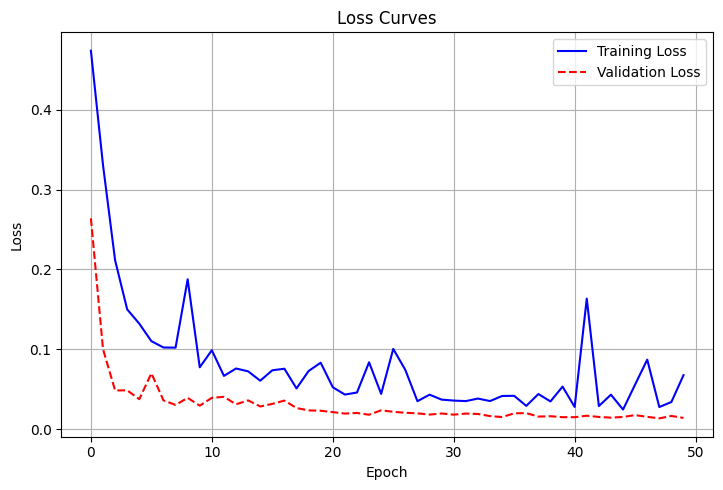

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []  
val_f1s = []
best_val_f1 = 0

for epoch in range(1, 51):
    train_loss = train()
    val_loss, val_f1 = validate() 
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pt')
        
    print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-')
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()



## Test Set Performance ##
              precision    recall  f1-score   support

     Support       1.00      0.98      0.99       179
      Attack       0.50      1.00      0.67         2
 No Relation       0.99      1.00      1.00       189

    accuracy                           0.99       370
   macro avg       0.83      0.99      0.89       370
weighted avg       0.99      0.99      0.99       370



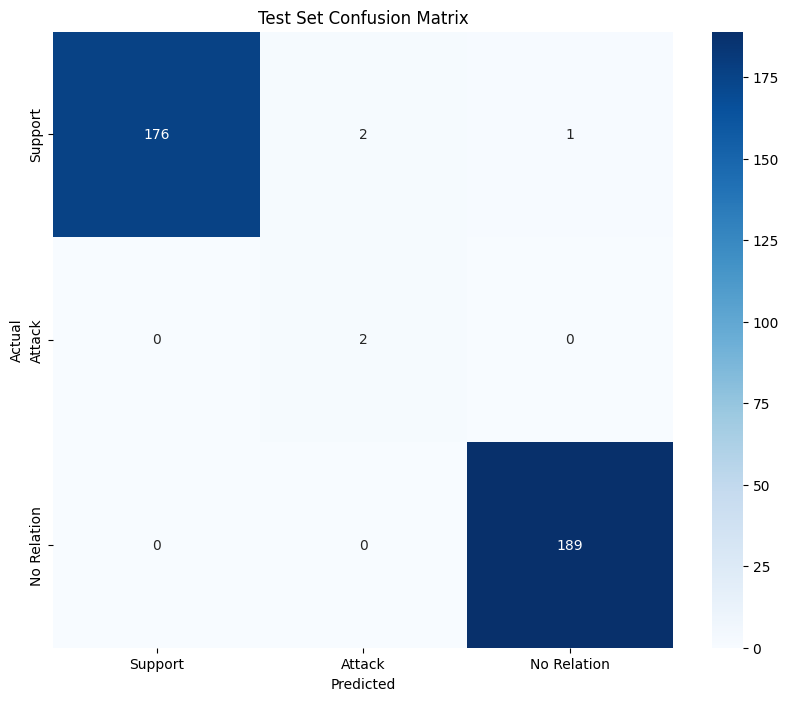

In [ ]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_test_set(model, test_docs):
    model.eval()
    all_preds = []
    all_true = []
    
    for data in test_docs:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.edge_type)
            preds = out.argmax(dim=1).cpu().numpy()
            true = data.edge_type.cpu().numpy()
            
            all_preds.extend(preds)
            all_true.extend(true)
    
    print("\n## Test Set Performance ##")
    print(classification_report(all_true, all_preds, 
                               labels=[0,1,2], 
                               target_names=['Support', 'Attack', 'No Relation'],
                               zero_division=0))
    
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Support', 'Attack', 'No Relation'],
                yticklabels=['Support', 'Attack', 'No Relation'])
    plt.title('Test Set Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('test_confusion_matrix.png')
    plt.show()

evaluate_test_set(model, test_docs)
